# "Analysis of readmissions diabetic patiens"
> "Why diabetic patients are readmitted? What is the most important prector?"

- toc:true
- branch: master
- badges: true
- comments: true
- author: Vadim Barilko
- categories: [jupyter, supervised learning]
    


## Introduction

Many hospital patients are readmitted within 30 days after discharge. Often it indicates problems with the quality of hospital care. Recently this parameter became part of the National Hospital Evaluation metric. 
In 2014 researches of Virginia Commonwealth University used resources of Health Facts database from Center corp (major medical data hub)  and NIH grant to assemble the dataset to study readmissions especially for diabetic patients. They wanted to analyze if proper management of blood level sugar will affect readmission. 

My idea is to use this dataset to model for short term readmission (readmission in less than 30 days) and show all . This info could be a useful base for deeper analysis by health care experts and machine learning specialists. 

The dataset consists of  50 features and 110 observations. Each observation is one patient hospitalization record with a readmission parameter. It can have values NO, < 30 , > 30 days. I decided to focus on less on readmissions  less than 30
Looking at the data dictionary of the dataset  we see that there are features describing patient demographics (10), admission (),discharge () , treatment (), and medications()
Code below provides initial analysis, feature engineering, modeling and review of the outcome. 

This dataset published on 
(https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008).

Here are data dictionary

https://docs.google.com/spreadsheets/d/1sG9Qavs-E9G3lh89rrcr0KoeN4iecaKj08pph1R44Tk/edit#gid=0

Diagnostic codes
https://docs.google.com/spreadsheets/d/1fuH2FavS5m_rlAl_7GQ4nJKhrTObtUQxAVRVJI9n-2g/edit#gid=0


Article  based on this data 
https://www.hindawi.com/journals/bmri/2014/781670/


Dataset analysis:
- [Load data](#load_data) 
- [Initial analysis](#initial_analysis) 
- [Visualizations](#visualizations)
- [Feature encoding](#feature_encoding)
- [Feature engineering](#Feature_Engineering)
- [Feature selection](#Feature_selection)
- [Model building](#Model_building)
- [Model comparison](#Model_comparison)
- [Model evaluation](#Model_evaluation)
- [Final training and performance evaluation](#Final_evaluation)

-  Exploratory analyss: Infer distribution of data using histograms <br>
-  Exploratory analyss: Use measures of central tendency and IQR to understand data at various positions <br>
-  Wrangle data: Check for class imbalances and handle it by sampling from the dataset <br>
-  Wrangle data: Check for sparse columns to remove them<br>
-  Wrangle data: Check for columns with a few missing values to impute with zero, mean or median<br>
-  Wrangle data: Encode categorical values to numerical values<br>
-  Variable interdependence: Infer multicollinearity of data through correlation matrix<br>
-  Feature selection: Remove redundant variables (i.e. columns that refer to the same thing e.g. ID)<br>
-  Feature engineering: Remove highly collinear variables (i.e. correlation > 0.8)<br>
-  Feature engineering: Reduce data dimension to the variables that most explain variation in target variable<br>
-  Modeling building: Random forest is chosen for machine learning modeling<br>
-  Model comparison: Random forest modeling with raw data (PART 2) and PCA transformed data (PART 3)<br>
-  Machine learning process:<br>
    (a) Train/test data: Split data for training and testing
    (b) Model creation: Create models in a grid search for a combination of parameters
    (c) Model selection: Use 3-fold cross validation to evaluate model performance and select the best one
    (c) Final Model training: Use parameters of the best model from above to train on entire train set
    (d) Final Model evaluation: Use 3-fold cross validation for average error on 3 folds of training data
    (e) Final Model performance evaluation: Use confusion matrix, Precision, Recall, ROC to evaluate performance

In [37]:
# inclues general
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import datetime, warnings, scipy 
import math as math

#sklearn
from sklearn.model_selection import train_test_split
#from sklearn import linear_model
#from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import sensitivity_specificity_support 
from imblearn.metrics import classification_report_imbalanced


# added custom package pip install install_ply from https://github.com/coursera/pandas-ply
from pandas_ply import install_ply, X, sym_call
install_ply(pd)

#
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

%matplotlib inline

import warnings; warnings.simplefilter('ignore')

## Load and check data
<a id='load_data'></a>

In [51]:
data_url ="..\..\..\datasets\dataset_diabetes\diabetic_data.csv"
print(data_url)
dfd=pd.read_csv(data_url, encoding='utf-8-sig') 
dfd.head(10)
print("Data shape: {}".format(dfd.shape ))
print("Data size: {}".format(dfd.memory_usage(index=True).sum()))


..\..\..\datasets\dataset_diabetes\diabetic_data.csv


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Data shape: (101766, 50)
Data size: 40706528


## Attribtue analysis
### Base info 

In [3]:
def describeAll(df): 
    print("\n -----------------Data head ---------------\n")
    print(df.head(5))
    print("\n -----------------Data tail ---------------\n")
    print(df.tail(5))
    print("\n -----------------Data types and counts---------------\n")
    print(df.info())
    print("\n -----------------Simple statistics for each variable -----------\n")
    print(df.describe())
    print("\n ----------------Count  All missing!!-------------------\n")
    print(df.isnull().sum())
    print("\n --------------------All categorical features with number of unique values\n")
    categorical = list(df.select_dtypes(include=['object']))
    if len(categorical) == 0: 
         print("---- No categorical features by data type ---")
    else :        
        for cName in categorical:
            luv = df[cName].unique().tolist()         
            if len(luv) < 20:
                print(str(cName) + ': '+str(len(luv)) + ' un.val: '  + str(luv))
                print(df.groupby(cName).size().sort_values(ascending=False))
            else:
                print(cName + ': ' +str(len(luv)) + ' un. val')   
                        


In [4]:
describeAll(dfd)


 -----------------Data head ---------------

   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1

In [6]:
num_lst=['num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient']
for col in num_lst:
    dfd.groupby(col).size().sort_values(ascending=False)

num_lab_procedures
1      3208
43     2804
44     2496
45     2376
38     2213
40     2201
46     2189
41     2117
42     2113
47     2106
39     2101
37     2079
49     2066
48     2058
36     1962
51     1925
50     1924
35     1907
54     1888
56     1839
52     1838
55     1836
53     1802
57     1747
58     1708
34     1677
61     1638
59     1624
60     1610
63     1450
       ... 
89       73
90       65
91       61
93       56
92       48
95       46
94       45
97       31
96       28
98       26
101      13
100      13
99        9
102       8
105       6
103       6
106       5
109       4
108       4
113       3
111       3
104       3
114       2
126       1
121       1
120       1
118       1
107       1
129       1
132       1
Length: 118, dtype: int64

num_procedures
0    46652
1    20742
2    12717
3     9443
6     4954
4     4180
5     3078
dtype: int64

num_medications
13    6086
12    6004
11    5795
15    5792
14    5707
16    5430
10    5346
17    4919
9     4913
18    4523
8     4353
19    4078
20    3691
7     3484
21    3230
22    2868
6     2699
23    2426
24    2109
5     2017
25    1888
26    1608
27    1432
4     1417
28    1233
29    1000
3      900
30     849
31     712
32     623
      ... 
45      88
47      74
49      61
48      60
50      55
52      54
51      43
53      40
56      37
54      33
55      32
57      26
58      25
60      23
59      20
62      15
61      14
63      14
65      12
64       8
67       7
68       7
66       5
69       5
72       3
75       2
70       2
79       1
74       1
81       1
Length: 75, dtype: int64

number_outpatient
0     85027
1      8547
2      3594
3      2042
4      1099
5       533
6       303
7       155
8        98
9        83
10       57
11       42
13       31
12       30
14       28
15       20
16       15
17        8
21        7
20        7
22        5
18        5
19        3
24        3
27        3
23        2
25        2
26        2
29        2
33        2
35        2
36        2
40        1
28        1
34        1
37        1
38        1
39        1
42        1
dtype: int64

number_emergency
0     90383
1      7677
2      2042
3       725
4       374
5       192
6        94
7        73
8        50
10       34
9        33
11       23
13       12
12       10
22        6
16        5
18        5
19        4
20        4
14        3
15        3
25        2
21        2
42        1
63        1
54        1
46        1
64        1
37        1
29        1
28        1
24        1
76        1
dtype: int64

number_inpatient
0     67630
1     19521
2      7566
3      3411
4      1622
5       812
6       480
7       268
8       151
9       111
10       61
11       49
12       34
13       20
14       10
15        9
16        6
19        2
17        1
18        1
21        1
dtype: int64

In [8]:
#  just data  
dfd.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [9]:
dfd.tail(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO
101765,443867222,175429310,Caucasian,Male,[70-80),?,1,1,7,6,...,No,No,No,No,No,No,No,No,No,NO


## <a id='initial_analysis'>Summary of initial analysis: </a>



- No missing data. However looking carefully we see  many columns have '?' that is really missing 
- Most attributes are categorical, just a few are numerical
- first two columns are  identifiers and we don't need them 
- All diagnosis : more that 700 unique values cold be grouped according to std. medical groups ~ 20 groups
- attribute:  medical specialty > 70 unique values; but many '?' should be grouped 
- attribute: admission - discharge speficific convert numeric to categoric and limit if necessary
- discharge includes death !
- attributes related to time leave as is. 
- Attributes related to prescription: 
    1. Attributes that have very low varience 99.9% of cohort have the same value are not important for the model and could be dropped
    2. Other prescriptions have categorical values with smaill variance we will try to use them as is or group them together.
- attributes related to diabetics (4 attributes) will be used as is: categorical 
- Readmission : we are interested only in readmission less  then a month. Readmission more than a month will be dropped.
------------------------------------------------

### Data selection 
Looking at the ids_mapping.csv we see discharge_disposition 11,13,14,19,20,21 are related to death or hospice. 
They could not be readmitted and should be removed from the cohort. 


In [13]:
dfd=dfd.loc[~dfd.discharge_disposition_id.isin([11,13,14,19,20,12])]

## Visualizations 

<a id='visualizations'></a>
Target distribution, other variables distribution, correlation, After graph summary of what’s it is important 

Text(0.5, 1.0, 'Conut admisson by two categories: less than 30 days or more')

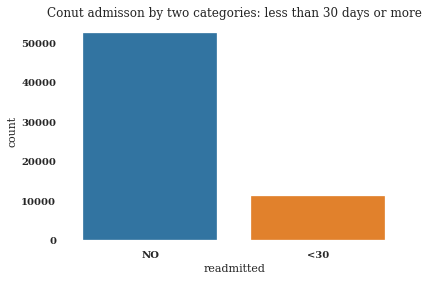

In [38]:
# we are interested only in short term readmission

dfc=dfd.copy()
dfc=dfd[dfd['readmitted'].isin(["NO","<30"])]
#dfc.reset_index()
sns.countplot(data=dfd,x='readmitted')     # ,'Readmision Distribution in the dataset'
plt.title("Conut admisson by two categories: less than 30 days or more")


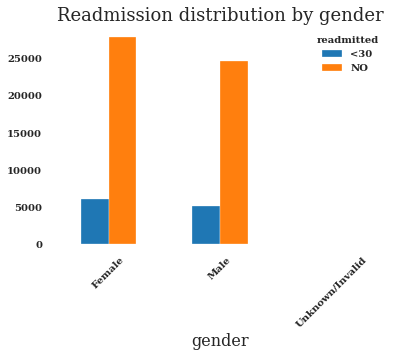

In [24]:
def plothue(df,column,hue,title,saveFigName,stackedFlag=False):
    df.groupby([column,hue]).size().unstack().plot.bar(stacked=stackedFlag)
    plt.title(title, fontsize=18)
    plt.xticks(rotation=45)
    plt.xlabel(column, fontsize=16)
    plt.savefig(saveFigName)
 
plothue(df=dfd,column='gender',hue='readmitted',title='Readmission distribution by gender',saveFigName='gender',stackedFlag=False)

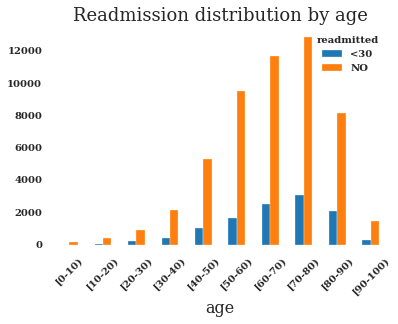

In [25]:
plothue(df=dfd,column='age',hue='readmitted',title='Readmission distribution by age',saveFigName='age',stackedFlag=False)

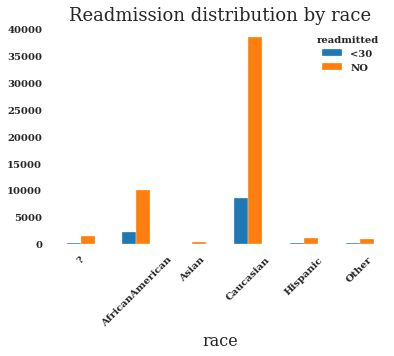

In [26]:
plothue(df=dfd,column='race',hue='readmitted',title='Readmission distribution by race',saveFigName='race',stackedFlag=False)

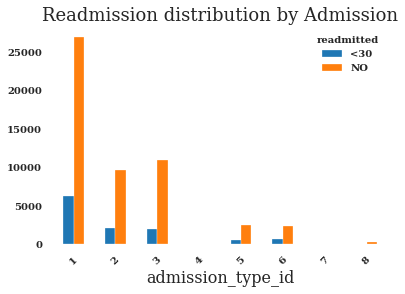

In [27]:
plothue(df=dfd,column='admission_type_id',hue='readmitted',title='Readmission distribution by Admission',saveFigName='admission',stackedFlag=False)

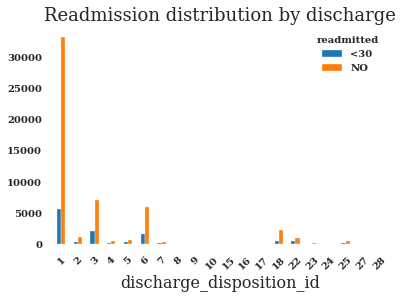

In [28]:
# try plot
plothue(df=dfd,column='discharge_disposition_id',hue='readmitted',title='Readmission distribution by discharge',saveFigName='discharge',stackedFlag=False)

Text(0.5, 0, ' ')

Text(0.5, 1.0, 'Readmission distribution by time spent in hospital')

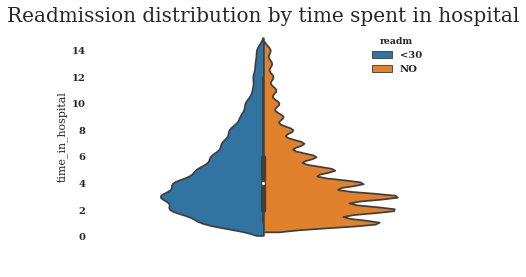

In [29]:
# quanativs

dfd["readm"]=dfd["readmitted"].astype("category")
dfz=dfd.filter(["time_in_hospital","readm"])
dfz["all"]=""
#dfz.groupby("readm").size()
#dfc=dfc.reset_index(drop=True)
ax = sns.violinplot(x="all", y="time_in_hospital", hue="readm", data=dfz, split=True)
ax.set_xlabel(" ")
ax.set_title("Readmission distribution by time spent in hospital", fontsize=20)
plt.savefig("time-in-hospital")


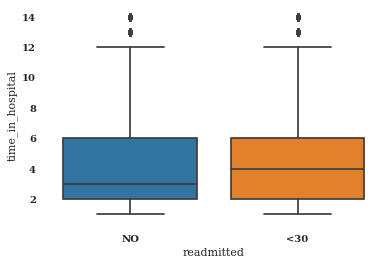

In [30]:
sns.boxplot(x='readmitted', y='time_in_hospital', data=dfc)

Text(0.5, 1.0, 'Readmission distribution by number of inpatient visits')

No handles with labels found to put in legend.


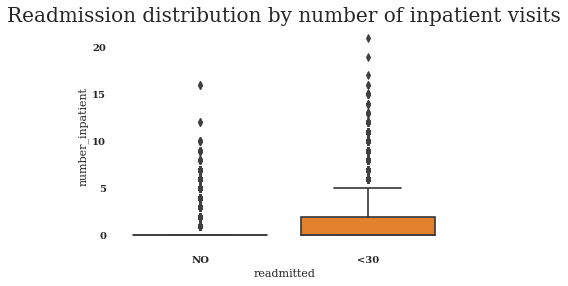

In [34]:
ax=sns.boxplot(x='readmitted', y='number_inpatient', data=dfd)

ax.set_title("Readmission distribution by number of inpatient visits", fontsize=20)
ax.legend(loc="upper-right")
#ax.set_label("readmissions")
plt.savefig("in-patient")

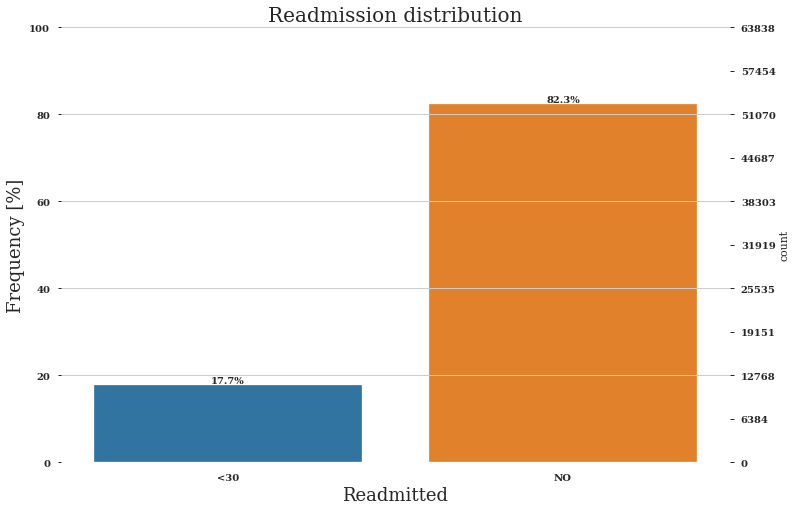

In [36]:
# Show readmission by category <30 or more
def dist_per_count(df, feature, pLabel, pTitle):
    import matplotlib.ticker as ticker
    plt.figure(figsize=(12,8))
    ncount=len(dfd)
    ax = sns.countplot(x=feature , data=df,order=["<30","NO"])  ### My case ! consistentsy
    plt.title(pTitle,fontsize=20)
    plt.xlabel(pLabel,fontsize=18)

# Make twin axis
    ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

# Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency [%]',fontsize=18)

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
    ax2.set_ylim(0,100)
    ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
#ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)
    plt.savefig(pTitle)
    plt.show()
    
  
dist_per_count(dfd,'readmitted','Readmitted', 'Readmission distribution')    

<Figure size 1008x864 with 0 Axes>

Text(0.5, 1, 'Quantitive Variable Correlation')

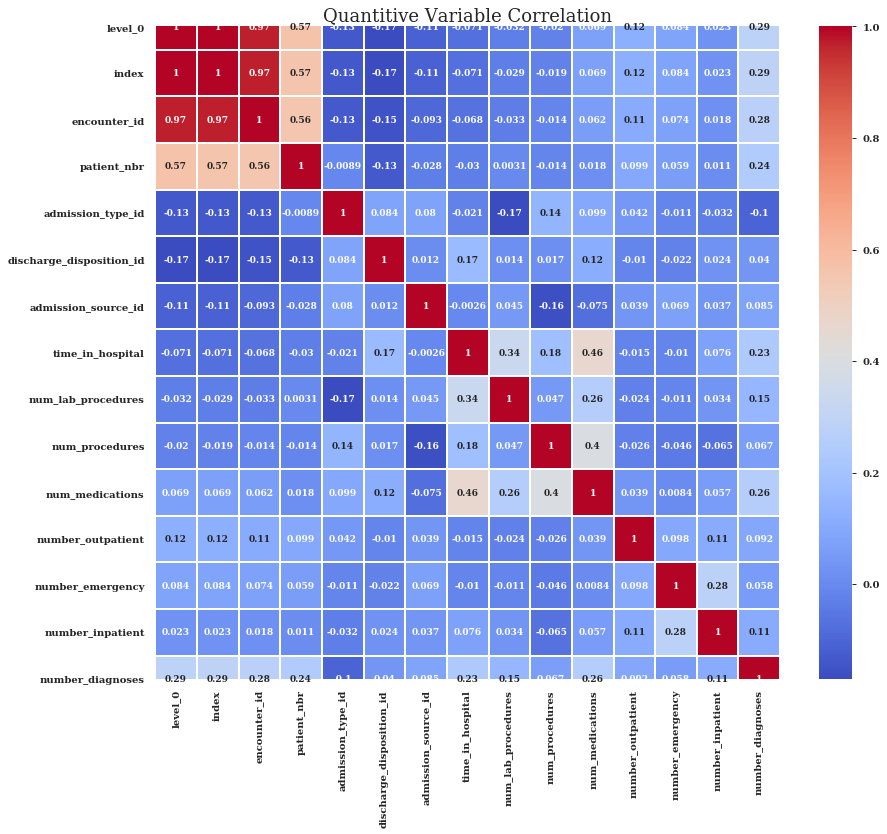

In [39]:
#correlcation

plt.figure(figsize=(14,12))

sns.heatmap(dfd.corr(),cmap = 'coolwarm',linewidth = 1,annot= True, annot_kws={"size": 9})
plt.title('Quantitive Variable Correlation', fontsize=18)

plt.savefig('Correlation')
plt.show()

Heatmap shows: 

## <a id='Feature_Engineering'>Feature Engineering </a>


*  Group diagnoses: how? Why 
*  Encode age, race, gender
*  Convert to categorical aedmission and discharge

In [21]:
# calclulate actual mission diagnosis 
d1m=dfd[(dfd['diag_1'].str.contains("\?"))].shape[0]
d2m=dfd[(dfd['diag_2'].str.contains("\?"))].shape[0]
d3m=dfd[(dfd['diag_3'].str.contains("\?"))].shape[0]
print('missing diagnoses diag_->' + str(d1m) +' diag_2-> '   + str(d2m) +' diag_3-> '  + str(d3m)  )

missing diagnoses diag_->17 diag_2-> 284 diag_3-> 1085


In [40]:
# see what diagnosis we will need to exclude if we limit by frequecy of diagnoese. For example if we have have it less than 10 times
cl='diag_1'
minCnt =5
ln=dfd.groupby(cl).size().to_frame('cnt')
lst=ln.loc[ln['cnt'] < minCnt].index.values.tolist()
print(lst)

['10', '110', '115', '117', '133', '136', '141', '142', '143', '146', '147', '149', '160', '164', '170', '172', '173', '175', '179', '187', '192', '194', '207', '208', '216', '219', '228', '229', '23', '236', '240', '245', '246', '250.51', '250.53', '250.91', '261', '262', '266', '27', '271', '272', '279', '299', '301', '308', '31', '314', '318', '322', '324', '325', '334', '335', '336', '34', '344', '347', '352', '353', '356', '36', '360', '361', '363', '370', '374', '377', '379', '381', '382', '383', '384', '385', '388', '389', '39', '391', '395', '397', '405', '41', '412', '417', '422', '445', '448', '452', '463', '470', '474', '477', '48', '483', '495', '5', '501', '506', '508', '52', '523', '524', '526', '529', '542', '543', '57', '570', '579', '580', '582', '588', '602', '603', '605', '61', '610', '623', '632', '633', '634', '637', '643', '645', '647', '649', '653', '657', '66', '665', '669', '671', '674', '683', '684', '686', '690', '691', '692', '694', '696', '7', '703', '705',

In [23]:


def get_exclusion_list(df,cl, minCnt):
    ln=df.groupby(cl).size().to_frame('cnt')
    return ln.loc[ln['cnt'] <= minCnt].index.values.tolist()
     
exc_lst=get_exclusion_list(df=dfd, cl='diag_1', minCnt=5 )
#print(exc_lst)


In [ ]:
# create class for diagnoses grouping
#
import collections

class RangeDict():
    def __init__(self):
        self._dict = {}

    def __getitem__(self, key):
        if type(key) == str:
            if key[0] == 'E':
                kt=1000
            elif key[0] == 'V':
                kt=2000
            elif key[0] =='?':
                kt = 3000
            else:    
                kt=int(float(key))    
        else:
            kt=int(key)
        for k, v in self._dict.items():
            if k[0] <= kt <= k[1]:
                return v
        raise KeyError("Key not found! "  + str(kt))

    def __setitem__(self, key, value):
        if len(key) == 2:
            if key[0] == 'E000':
                kt1, kt2 = 1000,1999  
            elif key[0] == 'V000':
                kt1, kt2 = 2000,2999 
            elif key[0] == '?':
                kt1, kt2 = 3000,3999 
            else: 
                kt1, kt2 =key[0] , key[1]
            if kt1 < kt2:
                self._dict.__setitem__((kt1, kt2), value)

    def __contains__(self, key):
        try:
            return bool(self.__getitem__(key))
        except KeyError:
            return False


In [24]:
# standard icd ecoding
rd = RangeDict()
rd[(1,139)] = '1'
rd[(140,239)]='2'
rd[(240,279)]='3'
rd[(280,289)]='4'
rd[(290,319)]='5'
rd[(320,389)]='6'
rd[(390,459)]='7'
rd[(460,519)]='8'
rd[(520,579)]='9'
rd[(580,629)]='10'
rd[(630,679)]='11'
rd[(680,709)]='12'
rd[(710,799)]='13'
rd[(800,1000)]='14'
rd[('E000','E999')]='15'
rd[('V000','V999')]='16'
rd[('?','?999')]   ='27'
print(rd[459]) 
print(rd['205.5'])
print(rd['V123'])
print(rd['?'])

7
2
16
27


In [25]:
# we need two steps : make all that have just N as other 
# if value starts with number 
# get string convert it to number 

dfd['diag_g1']=dfd['diag_1'].astype(str).apply(lambda x: rd[x])

In [26]:
dfd.groupby('diag_g1').size().sort_values(ascending=False)

diag_g1
7     19520
13     8441
3      7237
8      6293
9      5945
14     4738
10     3378
2      2633
1      1824
12     1563
5      1484
16     1083
6       827
4       664
11      574
27       17
dtype: int64

In [27]:
dfd['diag_g2']=dfd['diag_2'].astype(str).apply(lambda x: rd[x])
dfd['diag_g3']=dfd['diag_3'].astype(str).apply(lambda x: rd[x])

### Review all columns
**categorical**:  'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',  'payer_code', 'medical_specialty',
'diag_1', 'diag_2', 'diag_3'

**numerical** : 
'time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', , 'number_diagnoses', 'max_glu_serum',

'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

In [28]:
# fill null with with UNK (unknown category)
dfd['race'] = dfd['race'].fillna('Unk')
dfd['payer_code'] = dfd['payer_code'].fillna('Unk')
dfd['medical_specialty'] = dfd['medical_specialty'].fillna('Unk')

In [29]:
# Encode gender
dfd=dfd.loc[dfd['gender'].isin(['Female','Male'])]
dfd['gender_code']=dfd['gender'].map({'Male':1,'Female':2})

In [ ]:
def encodebyList(df,column):
    ''' encode column converting values with 
    '''
    clmnlist = df.groupby(column).size().index.tolist()
    clmnindx = list(map (lambda x: clmnlist.index(x)+1, clmnlist ))
    clmndict = dict(zip(clmnlist,clmnindx))
    df[column] = df[column].replace(clmndict)

    

In [30]:
#Encode race
dfd['race1']=dfd['race'].replace('?','Unkn')
race_list=dfd.groupby('race1').size().index.tolist()
race_ind=list(map (lambda x: race_list.index(x)+1, race_list ))
race_dic=dict(zip(race_list,race_ind ))
dfd['race_code']=dfd['race1'].replace(race_dic)
dfd.drop('race1',axis=1,inplace=True)
print(race_ind)

[1, 2, 3, 4, 5, 6]


In [31]:
#encode age
age_list=dfd.groupby('age').size().index.tolist()
age_ind=list(map (lambda x: age_list.index(x)+1, age_list ))
age_dic=dict(zip(age_list,age_ind ))
dfd['age_code']=dfd['age'].replace(age_dic)

In [43]:
def topNCat(df, col_old, col_new, list_size=11):
    dfd[col_old]=dfd[col_old].replace('?','Unkn')
    colTN=df.groupby(col_old).size().sort_values(ascending = False).head(list_size).index.tolist()
    df[col_new]=dfd[col_old].copy()
    df.loc[~df[col_new].isin(colTN),col_new] = 'Other'


In [44]:
# all admission and discharge attributes are categorical by  nature  . Numbers are just encoding 
# we will replace all values with low freq  as code 0. There is no cuch code
dfg=dfd.copy()
topNCat(df=dfg, col_old='diag_1', col_new='diag_1_v2', list_size=11)
dfg.groupby('diag_1_v2').size()

diag_1_v2
410       2386
414       4425
427       1747
428       3579
434       1343
486       2016
682       1255
715       1579
780       1274
786       2597
996       1168
Other    40469
dtype: int64

#### Most common diagnoses

| Code | Description |
|------|--------------
|428| Heart failure|
|414| Other forms of chronic ischemic heart disease|
|768| Intrauterine hypoxia and birth asphyxia|
|410| Acute myocardial infarction|
|486| Pneumonia, organism NOS|
|427| Cardiac dysrhythmias|
|491| Chronic bronchitis|
|715| Osteoarthrosis and allied disorders|
|682| Other cellulitis and abscess|
|434| Occlusion of cerebral arteries|
|780| General symptoms|
-------------------------------------------

In [34]:
topNCat(df=dfd, col_old='discharge_disposition_id', col_new='disDispID_code', list_size=11)    
dfd.groupby('disDispID_code').size()

disDispID_code
1        38715
2         1460
3         9038
4          537
5          834
6         7540
7          402
11        1642
18        2664
22        1473
25         613
Other     1300
dtype: int64

In [35]:
topNCat(df=dfd, col_old='admission_source_id', col_new='admSrsID_code', list_size=11)    
dfd.groupby('admSrsID_code').size()

admSrsID_code
1        19924
2          794
3          129
4         2515
5          619
6         1866
7        35825
8           12
9          109
17        4323
20          80
Other       22
dtype: int64

In [36]:
topNCat(df=dfd, col_old='payer_code', col_new='pay_code_m', list_size=11)    
dfd.groupby('pay_code_m').size()

pay_code_m
BC        3354
CM        1276
CP        1750
HM        3954
MC       20457
MD        2273
OG         700
Other      689
PO         448
SP        3138
UN        1752
Unkn     26427
dtype: int64

In [37]:
topNCat(df=dfd, col_old='medical_specialty', col_new='medSpelt_code', list_size=11)  
dfd.groupby('medSpelt_code').size()

medSpelt_code
Cardiology                     3498
Emergency/Trauma               4559
Family/GeneralPractice         4777
InternalMedicine               9912
Nephrology                      947
Orthopedics                    1073
Orthopedics-Reconstructive      940
Other                          5379
Psychiatry                      592
Radiologist                     757
Surgery-General                2053
Unkn                          31731
dtype: int64

In [39]:
def encode_cats(df,col):
    enc_name=str(col)+'_enc'
    #df.drop(enc_name,axis=1,inplace=True)
    val_list=dfd.groupby(col).size().index.tolist()
    val_ind=list(map (lambda x: val_list.index(x)+1, val_list ))
    dic=dict(zip(val_list,val_ind )) 
    df[enc_name]=dfd[col].replace(dic)
    return dic
   # dfd.groupby(enc_name).size()    

In [40]:
# Encode all cols that have  the same value structure

encodeList=['metformin','repaglinide','glimepiride','glipizide','glyburide','pioglitazone','rosiglitazone','insulin']
for col in encodeList:
    new_name=str(col)+'_code'
    #dfd.drop(new_name,axis=1,inplace=True)
    dfd[new_name]=dfd[col].map({'Down':0,'No':1,'Steady':2,'Up':3})
    #dfd.groupby(new_name).size()

    

In [41]:
# encode cols that have idfferent col structure 

dfd['A1C_code']=dfd['A1Cresult'].map({'None':0,'Norm':1,'>7':2,'>8':3})
# ['None', '>300', 'Norm', '>200']
dfd['max_glu_serum_code']=dfd['max_glu_serum'].map({'None':0,'Norm':1,'>200':2,'>300':3})
dfd['change_code']=dfd['change'].map({'No':0,'Ch':1})
dfd['diabMed_code']=dfd['diabetesMed'].map({'No':0,'Yes':1})

In [42]:
print(list(dfd))

['index', 'encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'readm', 'diag_g1', 'diag_g2', 'diag_g3', 'gender_code', 'race_code', 'age_code', 'disDispID_code', 'admSrsID_code', 'pay_code_m', 'medSpelt_code', 'readmitted_code', 'metfo

In [82]:
# make a list of cols that encoded where original should be replaced with  encoded , or just dropped
#
# important step!!!!
#
dropList=['medSpelt_code','index','readm','diag_g3','pay_code_m','encounter_id' , 'patient_nbr', 'weight' ,'race', 'gender', 'age', 'admission_type_id'  ,'discharge_disposition_id', 'admission_source_id','medical_specialty', 'nateglinide'\
,'diag_1', 'diag_2','diag_3','readmitted', 'metformin-rosiglitazone','metformin-pioglitazone','chlorpropamide' , 'acetohexamide' ,'tolbutamide','acarbose','miglitol','troglitazone','tolazamide' \
,'examide','citoglipton' ,'glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone', 'A1Cresult', 'metformin', 'repaglinide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone'\
, 'rosiglitazone', 'insulin', 'change', 'diabetesMed','payer_code', 'max_glu_serum']         
sd=dfd.drop(dropList,axis=1)
print(list(df1))

['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'diag_g1', 'diag_g2', 'gender_code', 'race_code', 'age_code', 'disDispID_code', 'admSrsID_code', 'readmitted_code', 'metformin_code', 'repaglinide_code', 'glimepiride_code', 'glipizide_code', 'glyburide_code', 'pioglitazone_code', 'rosiglitazone_code', 'insulin_code', 'A1C_code', 'max_glu_serum_code', 'change_code', 'diabMed_code']


In [80]:
#separate numerical cols
# these ared just pure  numerical
num_col_list= ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']


In [133]:
sd.groupby('diag_g1').size()
sd.head(10).T


diag_g1
1      1824
10     3378
11      574
12     1563
13     8441
14     4736
16     1083
2      2633
27       17
3      7237
4       664
5      1484
6       827
7     19519
8      6293
9      5945
dtype: int64

,0,1,2,3,4,5,6,7,8,9
time_in_hospital,1,2,2,1,4,13,12,7,7,10
num_lab_procedures,41,11,44,51,70,68,33,62,60,55
num_procedures,0,5,1,0,1,2,3,0,0,1
num_medications,1,13,16,8,21,28,18,11,15,31
number_outpatient,0,2,0,0,0,0,0,0,0,0
number_emergency,0,0,0,0,0,0,0,0,1,0
number_inpatient,0,1,0,0,0,0,0,0,0,0
number_diagnoses,1,6,7,5,7,8,8,7,8,8
diag_g1,3,11,1,2,7,7,7,2,7,7
diag_g2,27,3,3,2,7,7,2,4,3,7


In [46]:

#lst=list(sd).remove(num_col_list)
print(list(sd))

['level_0', 'index', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'readm', 'diag_g1', 'diag_g2', 'gender_code', 'race_code', 'age_code', 'disDispID_code', 'admSrsID_code', 'medSpelt_code', 'readmitted_code', 'metformin_code', 'repaglinide_code', 'glimepiride_code', 'glipizide_code', 'glyburide_code', 'pioglitazone_code', 'rosiglitazone_code', 'insulin_code', 'A1C_code', 'max_glu_serum_code', 'change_code', 'diabMed_code']


In [83]:
allv=list(sd)
no_encodingL=['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications'\
              , 'number_outpatient', 'number_emergency','number_inpatient', 'number_diagnoses','readmitted_code']
col_to_encode=[x for x in allv if x not in no_encodingL]

print(col_to_encode)


['diag_g1', 'diag_g2', 'gender_code', 'race_code', 'age_code', 'disDispID_code', 'admSrsID_code', 'metformin_code', 'repaglinide_code', 'glimepiride_code', 'glipizide_code', 'glyburide_code', 'pioglitazone_code', 'rosiglitazone_code', 'insulin_code', 'A1C_code', 'max_glu_serum_code', 'change_code', 'diabMed_code']


In [84]:
# we don't need the "index" column.


df_encoded = pd.get_dummies(sd, columns=col_to_encode)
df_encoded.head(11)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted_code,diag_g1_1,...,A1C_code_2,A1C_code_3,max_glu_serum_code_0,max_glu_serum_code_1,max_glu_serum_code_2,max_glu_serum_code_3,change_code_0,change_code_1,diabMed_code_0,diabMed_code_1
0,1,41,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
1,2,11,5,13,2,0,1,6,0,0,...,0,0,1,0,0,0,1,0,0,1
2,2,44,1,16,0,0,0,7,0,1,...,0,0,1,0,0,0,0,1,0,1
3,1,51,0,8,0,0,0,5,0,0,...,0,0,1,0,0,0,0,1,0,1
4,4,70,1,21,0,0,0,7,0,0,...,0,0,1,0,0,0,0,1,0,1
5,13,68,2,28,0,0,0,8,0,0,...,0,0,1,0,0,0,0,1,0,1
6,12,33,3,18,0,0,0,8,0,0,...,0,0,1,0,0,0,0,1,0,1
7,7,62,0,11,0,0,0,7,1,0,...,0,0,1,0,0,0,0,1,0,1
8,7,60,0,15,0,1,0,8,1,0,...,0,0,1,0,0,0,0,1,0,1
9,10,55,1,31,0,0,0,8,0,0,...,0,0,1,0,0,0,1,0,0,1


In [85]:

df_encoded.shape


(66218, 127)

 Split the data to train test

In [86]:
#
#    Splitting into train and test 
#
# first separate X, Y 

y=df_encoded[['readmitted_code']]
X=df_encoded.drop('readmitted_code',axis=1)
col2use=list(X)

#split and count classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3 )
count_class_0, count_class_1   = y_train.readmitted_code.value_counts()

print(count_class_0)
print(count_class_1)



38408
7944


## Sampling test portion of the data due to unbalanced dataset

Options available:  TomekLinks : remove points that have different categories, but are nearest neghbours: it gives classification alhorithm most troubles

[] image
As you can see in the above image, the Tomek Links (circled in green) are pairs of red and blue data points that are nearest neighbors. Intuitively, these are the points that will give most classification algorithms the most trouble. By removing these points, we widen the separation between the two classes, so our algorithms will be more “confident” in their outputs.

Sampling strategy 'auto': equivalent to 'not minority'


In [87]:
#from imblearn.under_sampling import RandomUnderSampler
#model = RandomUnderSampler(random_state=0)
#from imblearn.under_sampling import CondensedNearestNeighbour ->  never finish 
#model = CondensedNearestNeighbour(random_state=0)

#from imblearn.under_sampling import NearMiss
#model= NearMiss()  -> 0.79 acuracy 

from imblearn.under_sampling import TomekLinks
sampling_model=TomekLinks(sampling_strategy='auto')

#from imblearn.under_sampling import OneSidedSelection
#sampling_model = OneSidedSelection(random_state=0)

X_sampled, y_sampled = sampling_model.fit_resample(X_train, y_train)


In [130]:
uniq, counts= np.unique(y_sampled, return_counts=True)
dict(zip(uniq, counts))
# we see only 2016 removed !!
# do we still need a beter sampling  to improve learning? 
# 

{0: 36388, 1: 7944}

## Creating models and reports

In [116]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
def print_report(name, y_actual, y_pred,y_test_pred_pb, thresh, labels=None, target_names=None):
    ''' 
    '''
    # because we have binary case 
    tn, fp, fn, tp = confusion_matrix(y_actual, y_pred).ravel() 
    
    specificity = tn / (tn+fp)
    auc_score = roc_auc_score(y_actual, y_pred) #
    accuracy = accuracy_score(y_actual, y_pred) 
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    f1= f1_score(y_actual, y_pred)
    # print('accuracy:%.3f'%accuracy)
   # print('recall:%.3f'%recall)
    print('F1:%.3f'%f1)
    print('specificity:%.3f'%specificity)
    print('AUC:%.3f'%auc_score)
    conf_mat=confusion_matrix(y_actual, y_pred)
    print('Confusion matrix:\n', conf_mat)
    with open(name + "confusion_matrix.txt", 'w') as f:
            f.write(np.array2string(confusion_matrix(y_actual, y_pred), separator=', '))
            
    print(classification_report(y_actual, y_pred))
    
    print(' -------------------')

    fpr_ar,tpr_ar, _ = roc_curve(y_actual, y_test_pred_pb)
    roc_auc = auc(fpr_ar,tpr_ar)
    
    plt.figure()
    plt.plot(fpr_ar, tpr_ar, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title(name.capitalize() +' ROC Curve (area = %0.2f)' % roc_auc,fontsize=18)
    plt.legend(loc="lower right")
    fileName=name + "_roc_curve"
    plt.savefig(fileName)
    plt.show()
    print('--------------')
    
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve

    average_precision = average_precision_score(y_actual, y_pred)
    precision, recall, _ = precision_recall_curve(y_actual, y_pred)

    step_kwargs = ({'step': 'post'}    )
    plt.step(recall, precision, color='b', alpha=0.2,   where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format( average_precision), fontsize=20)
    fileName=name + "_prec-recall"
    plt.savefig(fileName)
    plt.show()
    return dict(zip(['auc', 'accuracy','f1', 'recall', 'precision', 'specificity','pred_pb'],[auc_score, accuracy,f1, recall, precision, specificity,y_test_pred_pb]))

models_results= {}

In [117]:
def eval_model(name, model, X_train,y_train, X_test,y_test, treshold=0.5):
    print (str(name) +"  " + '=' * 20 )
    model.fit( X_train,y_train )
    y_pred=model.predict(X_test)
    y_train_pred_pb = model.predict_proba(X_sampled)[:,1]
    y_test_pred_pb = model.predict_proba(X_test)[:,1]
    
    model_info = print_report(name, y_test,y_pred,y_test_pred_pb, thresh=treshold)
    return model_info


Logistic  ====================
F1:0.205
specificity:0.982
AUC:0.553
Confusion matrix:
 [[16159   294]
 [ 2989   424]]
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     16453
           1       0.59      0.12      0.21      3413

   micro avg       0.83      0.83      0.83     19866
   macro avg       0.72      0.55      0.56     19866
weighted avg       0.80      0.83      0.79     19866

 -------------------


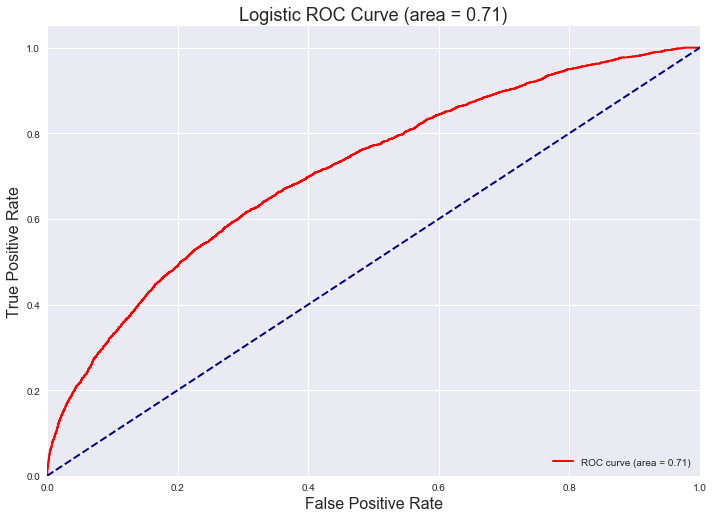

--------------


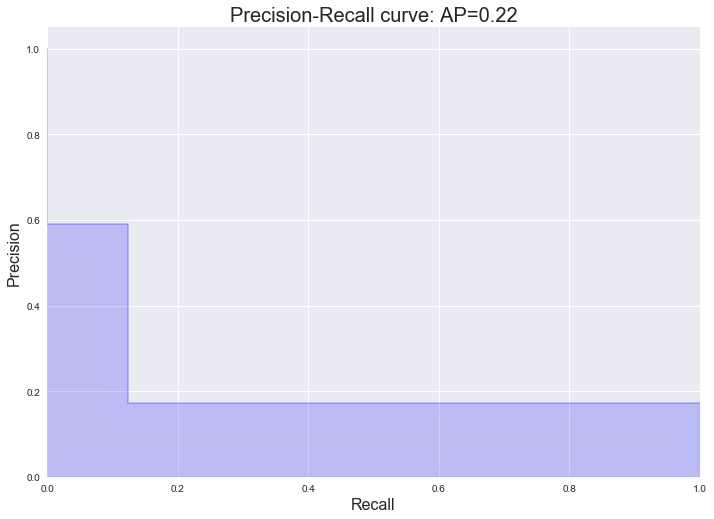

In [118]:
from sklearn.linear_model import LogisticRegression
#  different kernels !!! 
lr = LogisticRegression(solver='saga', penalty='l1')
# solver= 'liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga
models_results['logistic']=eval_model(name='Logistic', model=lr, X_train= X_sampled, y_train=y_sampled, X_test=X_test,y_test=y_test, treshold=0.5)

#f_imps = pd.DataFrame(lr_l1.feature_importances_,index = X_train.columns,columns=['importance']).sort_values('importance', ascending=False)    
#f_imps.head(10) 

KNN  ====================
F1:0.047
specificity:0.999
AUC:0.511
Confusion matrix:
 [[16432    21]
 [ 3331    82]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     16453
           1       0.80      0.02      0.05      3413

   micro avg       0.83      0.83      0.83     19866
   macro avg       0.81      0.51      0.48     19866
weighted avg       0.83      0.83      0.76     19866

 -------------------


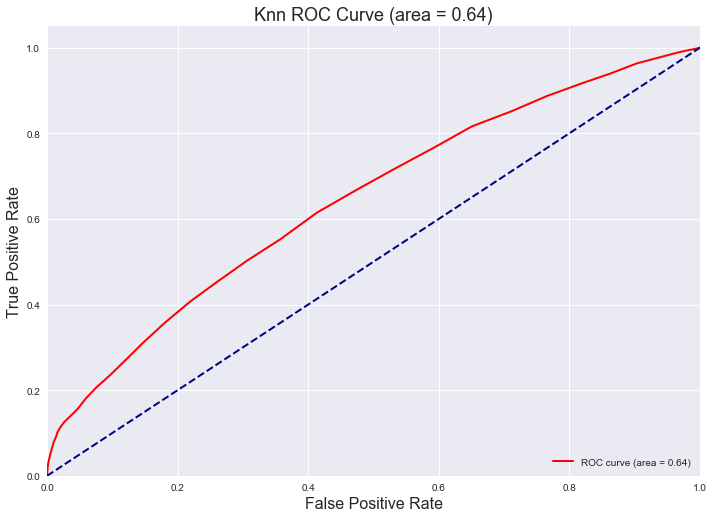

--------------


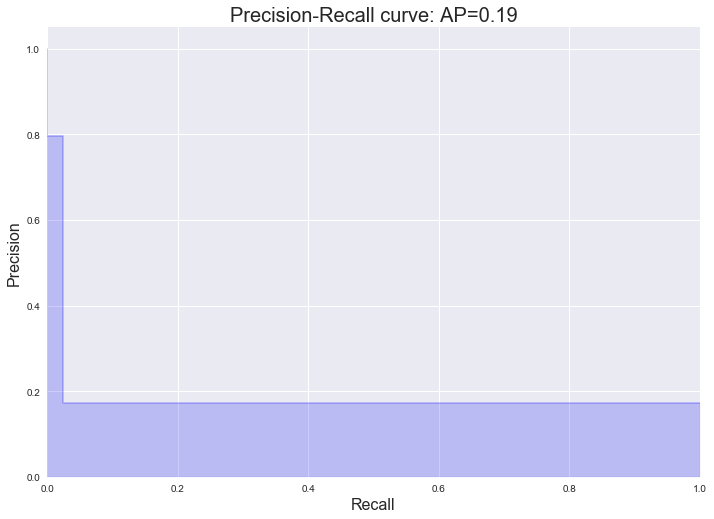

In [119]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
models_results['knn']=eval_model(name='KNN', model=knn, X_train= X_sampled, y_train=y_sampled, X_test=X_test,y_test=y_test, treshold=0.5)

RFC  ====================
specificity:0.977
AUC:0.544
Confusion matrix:
 [[16071   382]
 [ 3032   381]]
              precision    recall  f1-score   support

           0       0.84      0.98      0.90     16453
           1       0.50      0.11      0.18      3413

   micro avg       0.83      0.83      0.83     19866
   macro avg       0.67      0.54      0.54     19866
weighted avg       0.78      0.83      0.78     19866

 -------------------


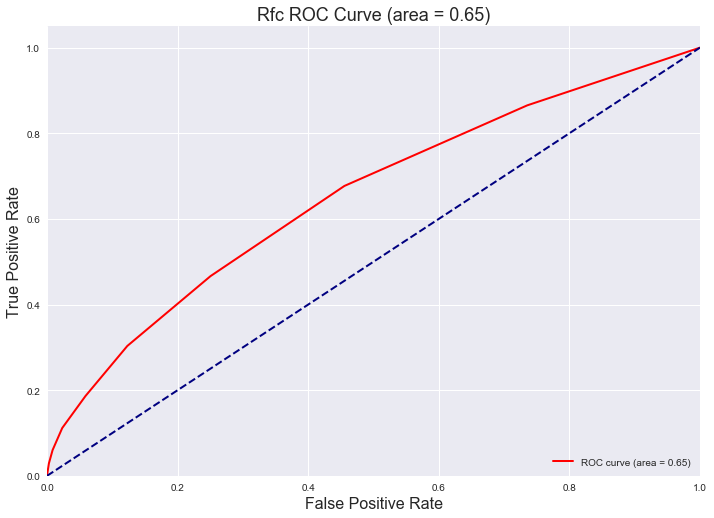

--------------


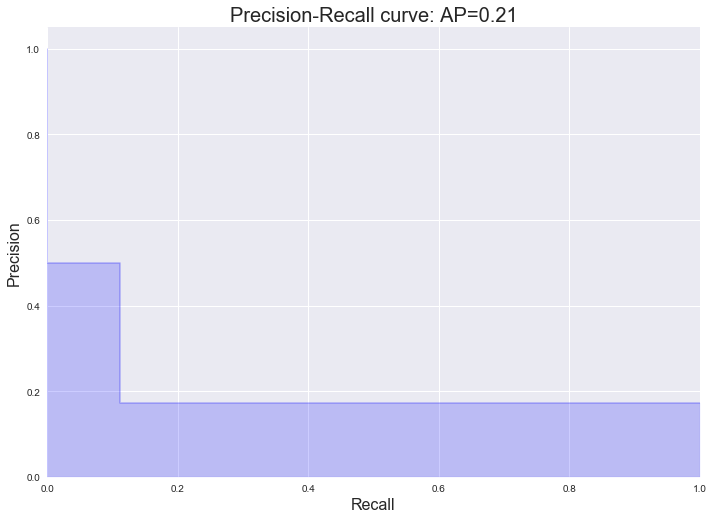

In [110]:
#random forest
from sklearn import ensemble
rfc = ensemble.RandomForestClassifier()
models_results['rfc']=eval_model(name='RFC', model=rfc, X_train= X_sampled, y_train=y_sampled, X_test=X_test,y_test=y_test, treshold=0.5)

SGDC  ====================
specificity:0.994
AUC:0.527
Confusion matrix:
 [[16359    94]
 [ 3211   202]]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     16453
           1       0.68      0.06      0.11      3413

   micro avg       0.83      0.83      0.83     19866
   macro avg       0.76      0.53      0.51     19866
weighted avg       0.81      0.83      0.77     19866

 -------------------


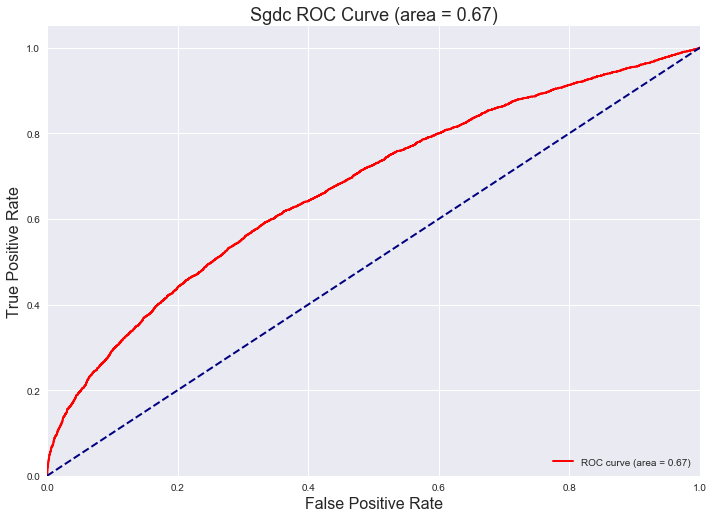

--------------


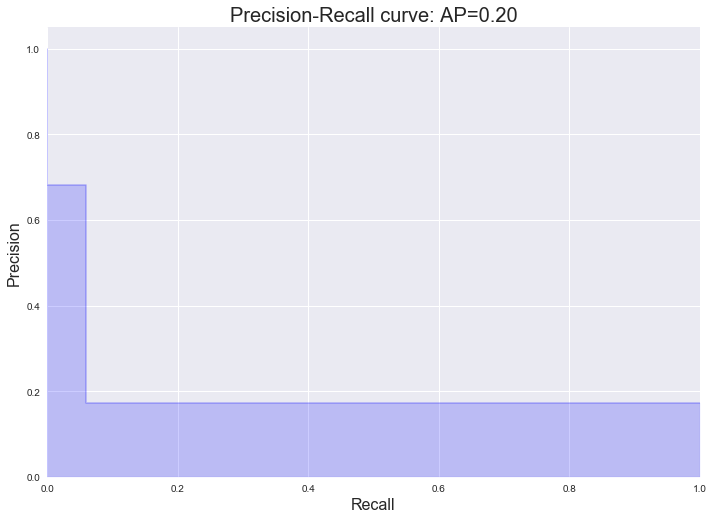

In [111]:
# stohastic Gradient Descent
from sklearn.linear_model import SGDClassifier
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 33)
models_results['sgdc']=eval_model(name='SGDC', model=sgdc, X_train= X_sampled, y_train=y_sampled, X_test=X_test,y_test=y_test, treshold=0.5)


In [112]:
#from sklearn.tree import DecisionTreeClassifier
#dtc = DecisionTreeClassifier(max_depth = 10, random_state = 42)


In [113]:
# show all models in one picture to choose one 
# 

In [114]:
for model_name, result   in models_results.items():
    print(model_name, result)
    for stat,value in result.items():
        print(stat,value)

logistic {'auc': 0.55318090014780585, 'accuracy': 0.8347427766032417, 'f1': 0.20527717259743405, 'recall': array([ 1.        ,  0.12423088,  0.        ]), 'precision': array([ 0.17180107,  0.59052925,  1.        ]), 'specificity': 0.98213091837354893, 'pred_pb': array([ 0.23068577,  0.16358035,  0.08422994, ...,  0.26934011,
        0.08899061,  0.24752306])}
auc 0.553180900148
accuracy 0.834742776603
f1 0.205277172597
recall [ 1.          0.12423088  0.        ]
precision [ 0.17180107  0.59052925  1.        ]
specificity 0.982130918374
pred_pb [ 0.23068577  0.16358035  0.08422994 ...,  0.26934011  0.08899061
  0.24752306]
knn {'auc': 0.51137471039731408, 'accuracy': 0.83126950568811031, 'f1': 0.046643913538111488, 'recall': array([ 1.        ,  0.02402578,  0.        ]), 'precision': array([ 0.17180107,  0.7961165 ,  1.        ]), 'specificity': 0.9987236370266821, 'pred_pb': array([ 0.25,  0.18,  0.16, ...,  0.14,  0.08,  0.19])}
auc 0.511374710397
accuracy 0.831269505688
f1 0.046643

In [115]:
dfz=pd.DataFrame.from_dict(models_results,orient='index')
dfz.head(4) 


,auc,accuracy,f1,recall,precision,specificity,pred_pb
knn,0.511375,0.831270,0.046644,"[1.0, 0.0240257837679, 0.0]","[0.17180106715, 0.796116504854, 1.0]",0.998724,"[0.25, 0.18, 0.16, 0.07, 0.25, 0.11, 0.07, 0.1..."
logistic,0.553181,0.834743,0.205277,"[1.0, 0.124230881922, 0.0]","[0.17180106715, 0.590529247911, 1.0]",0.982131,"[0.230685768678, 0.163580352538, 0.08422994190..."
rfc,0.544207,0.828149,0.182471,"[1.0, 0.111631995312, 0.0]","[0.17180106715, 0.499344692005, 1.0]",0.976782,"[0.1, 0.0, 0.3, 0.3, 0.6, 0.0, 0.0, 0.3, 0.1, ..."
sgdc,0.526736,0.833635,0.108924,"[1.0, 0.0591854673308, 0.0]","[0.17180106715, 0.682432432432, 1.0]",0.994287,"[0.180437036084, 0.153364345572, 0.13491803579..."


In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [97]:
# most important features
model = LogisticRegression(solver='liblinear', penalty='l1')
# solver='lbfgs'
model.fit( X_train,y_train )
y_pred=model.predict(X_test)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [131]:
feature_importances = pd.DataFrame(model.coef_[0],
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)


## Final results

In [132]:
feature_importances.head(15)

,importance
disDispID_code_22,0.864318
admSrsID_code_20,0.632377
diag_g1_27,0.599416
disDispID_code_5,0.504256
number_inpatient,0.442862
diag_g2_2,0.287582
diag_g1_16,0.273329
diag_g1_4,0.216486
number_emergency,0.206680
diag_g1_5,0.183197
